# Gas Stations in Mexico


![alt text](gas_station.jpg)

## Introduction

- Historically mexican population has been sensitive to fuel prices to the extent that it has even been a driver of political campaigns and discourse.
- Also, in recent times, customer service has become paramount in diverse areas related to the purchase of goods and services, 
- Finally, ourselves as fuel consumers, with the liberalization of prices from the energy reform, we wanted to see if added features influence consumption and ratings in Service Stations

We wanted to see if the data reflects our personal observations.

---

## Part 1 - Reading and preparing data

1. Import all the dependencies used in the project. 

In [1]:
import pandas as pd
import numpy as np
from numpy import NaN
import matplotlib.pyplot as plt
import requests
import json
import gmaps
from config import gkey

2. Define a function that will convert elements of a list into a single string that will be used later on the project.

In [2]:
def listToString(s):  
    
    # initialize an empty string 
    str1 = " " 
    
    # return string   
    return (str1.join(s)) 

3. Read data from two csv files and showing the first 5 rows to check how the data looks like

In [3]:
prices_file = "Resources/prices.csv"
places_file = "Resources/places.csv"
prices_df = pd.read_csv(prices_file)
places_df = pd.read_csv(places_file)

**Note:** The CSV files were originally XML files. Due to complexity of use with Python of that kind of file, we downloaded and converted both to CSV for better handling

In [4]:
prices_df.head()

,places,place,place_id,gas_price,type
0,NaN,NaN,11703.0,18.69,regular
1,NaN,NaN,NaN,19.69,premium
2,NaN,NaN,11702.0,18.19,regular
3,NaN,NaN,NaN,19.79,premium
4,NaN,NaN,NaN,18.25,diesel


In [5]:
prices_df.shape

(33215, 5)

In [6]:
places_df.head()

,name,cre_id,location/x,location/y,_place_id
0,"ESTACION DE SERVICIO CALAFIA, S.A. DE C.V.",PL/658/EXP/ES/2015,-116.92140,32.47641,2039
1,"DIGEPE, S.A. DE C.V. (07356)",PL/902/EXP/ES/2015,-99.74484,20.30370,2040
2,"DIAZ GAS, S.A. DE C.V.",PL/760/EXP/ES/2015,-106.45140,31.71947,2041
3,"COMBU-EXPRESS, S.A. DE C.V.",PL/825/EXP/ES/2015,-103.30420,20.71413,2042
4,"PETROMAX, S.A. DE C.V.",PL/585/EXP/ES/2015,-98.29977,26.03787,2043


In [7]:
places_df.shape

(12753, 5)

4. The prices_id base had to be managed, so we filled every "NaN" value of place_id with the corresponding ID from one cell above.

In [8]:
# Creating a column to replace NaNs with Places_ID
Place_ID = prices_df['place_id'].fillna(method='ffill')
# Adding Column to existing prices DataFrame
prices_df['Place_ID'] = Place_ID
# Eliminating original place_id from DataFrame
prices_df = prices_df.drop('place_id', axis = 1)
# Rearrange DataFrame
prices_df = prices_df[['Place_ID','gas_price','type']]
# Rename Place_ID
prices_df.columns = ['_place_id', 'gas_price','type']
prices_df.head()

,_place_id,gas_price,type
0,11703.0,18.69,regular
1,11703.0,19.69,premium
2,11702.0,18.19,regular
3,11702.0,19.79,premium
4,11702.0,18.25,diesel


5. Merging both DF into a single one by "_place_id" and renaming columns

In [9]:
Gas_Stations_df = pd.merge(places_df, prices_df, on="_place_id")
Gas_Stations_df = Gas_Stations_df.rename(columns={"_place_id":"place_id",
                                                 "location/x":"Lng",
                                                 "location/y":"Lat",
                                                 "type":"gas type"})
Gas_Stations_df


,name,cre_id,Lng,Lat,place_id,gas_price,gas type
0,"ESTACION DE SERVICIO CALAFIA, S.A. DE C.V.",PL/658/EXP/ES/2015,-116.92140,32.47641,2039,17.39,regular
1,"ESTACION DE SERVICIO CALAFIA, S.A. DE C.V.",PL/658/EXP/ES/2015,-116.92140,32.47641,2039,19.35,premium
2,"ESTACION DE SERVICIO CALAFIA, S.A. DE C.V.",PL/658/EXP/ES/2015,-116.92140,32.47641,2039,18.45,diesel
3,"DIGEPE, S.A. DE C.V. (07356)",PL/902/EXP/ES/2015,-99.74484,20.30370,2040,18.65,regular
4,"DIGEPE, S.A. DE C.V. (07356)",PL/902/EXP/ES/2015,-99.74484,20.30370,2040,18.99,premium
...,...,...,...,...,...,...,...
33210,GRUPO GASOLINERO DEL DIAMANTE HOLZ SA DE CV,PL/23508/EXP/ES/2020,-103.40990,22.83751,27300,18.59,premium
33211,GRUPO GASOLINERO DEL DIAMANTE HOLZ SA DE CV,PL/23508/EXP/ES/2020,-103.40990,22.83751,27300,18.89,diesel
33212,JAGREGAS 2 S.A. DE C.V.,PL/23510/EXP/ES/2020,-100.41290,20.67198,27304,16.99,regular
33213,JAGREGAS 2 S.A. DE C.V.,PL/23510/EXP/ES/2020,-100.41290,20.67198,27304,17.30,premium


---
## Part 2 - Setting up parameters and columns to use Google API

1. Creating a column for each new type of data we want to get.

In [10]:
Gas_Stations_df["Rating"] = ""
Gas_Stations_df["User Ratings"] ="" 
Gas_Stations_df["Google_Name"] = ""
Gas_Stations_df["Address"]= ""
Gas_Stations_df["Types"]= ""
Gas_Stations_df.head()

,name,cre_id,Lng,Lat,place_id,gas_price,gas type,Rating,User Ratings,Google_Name,Address,Types
0,"ESTACION DE SERVICIO CALAFIA, S.A. DE C.V.",PL/658/EXP/ES/2015,-116.92140,32.47641,2039,17.39,regular,,,,,
1,"ESTACION DE SERVICIO CALAFIA, S.A. DE C.V.",PL/658/EXP/ES/2015,-116.92140,32.47641,2039,19.35,premium,,,,,
2,"ESTACION DE SERVICIO CALAFIA, S.A. DE C.V.",PL/658/EXP/ES/2015,-116.92140,32.47641,2039,18.45,diesel,,,,,
3,"DIGEPE, S.A. DE C.V. (07356)",PL/902/EXP/ES/2015,-99.74484,20.30370,2040,18.65,regular,,,,,
4,"DIGEPE, S.A. DE C.V. (07356)",PL/902/EXP/ES/2015,-99.74484,20.30370,2040,18.99,premium,,,,,


2. We created a sub DataFrame to get unique results for each gas station, so we didn't have to repeat the requests on Google API

In [11]:
gas_id = Gas_Stations_df.drop_duplicates(subset="place_id")
gas_id = gas_id.reset_index(drop=False)
gas_id.head()

,index,name,cre_id,Lng,Lat,place_id,gas_price,gas type,Rating,User Ratings,Google_Name,Address,Types
0,0,"ESTACION DE SERVICIO CALAFIA, S.A. DE C.V.",PL/658/EXP/ES/2015,-116.92140,32.47641,2039,17.39,regular,,,,,
1,3,"DIGEPE, S.A. DE C.V. (07356)",PL/902/EXP/ES/2015,-99.74484,20.30370,2040,18.65,regular,,,,,
2,6,"DIAZ GAS, S.A. DE C.V.",PL/760/EXP/ES/2015,-106.45140,31.71947,2041,12.82,regular,,,,,
3,8,"COMBU-EXPRESS, S.A. DE C.V.",PL/825/EXP/ES/2015,-103.30420,20.71413,2042,18.64,regular,,,,,
4,11,"PETROMAX, S.A. DE C.V.",PL/585/EXP/ES/2015,-98.29977,26.03787,2043,14.79,regular,,,,,


3. Setting up the url and parameters for the API request

In [12]:
# URL
url_base = "https://maps.googleapis.com/maps/api/place/nearbysearch/json"

# Parameters
params = {
    "rankby":"distance",
    "type": "gas_station",
    "keyword": "fuel station",
    "key": gkey    
}

3. Because a 12,000+ calls had to be made to the API, we splitted up our database into five equal parts to use different api_keys

In [13]:
carlos_df = gas_id.iloc[0:2491,:]
rodrigo_df = gas_id.iloc[2491:4983,:]
pau_df = gas_id.iloc[4983:7475,:]
eduardo_df = gas_id.iloc[7475:9967,:]
sam_df =  gas_id.iloc[9967:12460,:]

4. Initiating the loop to get the results for every Sub-DataFrame created

In [14]:
 # Here we change the name of the DataFrame that was used for the loop
active_df = carlos_df

# We use iterrrows so we are able to get Latitude and Longitude from each row and insert both as one variable in params
for index, row in active_df.head().iterrows():
    lat=row["Lat"]
    lon=row["Lng"]

    # We add the location as variable of the parameters, which is the most important one for our requests
    params["location"] = f"{lat},{lon}"
    
    # We use this print to check that every requests is executing
    print(f"Results for observation: {index}")
    
    # We try to store the values Rating, User Ratings, the name given by Google to that location and its address
    try:
        response = requests.get(url_base, params=params).json()
        active_df.loc[index, "Rating"] = response["results"][0]["rating"]
        active_df.loc[index, "User Ratings"] = response["results"][0]["user_ratings_total"]
        active_df.loc[index, "Google_Name"] = response["results"][0]["name"]
        active_df.loc[index, "Address"] = response["results"][0]["vicinity"]

    # We also inserted the types of establishment the gas station has, here is where we use the function defined on the top
        string = response["results"][0]["types"]
        string_value = listToString(string)
        string_value = string_value.replace(" ",", ")
        active_df.loc[index, "Types"] = string_value
    except (KeyError, IndexError):
        print("Missing field/result... skipping.")


Results for observation: 0


C:\Users\Carlo\anaconda3\lib\site-packages\pandas\core\indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


Results for observation: 1
Results for observation: 2
Results for observation: 3
Results for observation: 4


5. After obtaining all the data, we stored the 5 parts in different csv Files, read them and then concatenate them to get a final DataFrame for Unique Stations

In [15]:
carlos_df.head()

,index,name,cre_id,Lng,Lat,place_id,gas_price,gas type,Rating,User Ratings,Google_Name,Address,Types
0,0,"ESTACION DE SERVICIO CALAFIA, S.A. DE C.V.",PL/658/EXP/ES/2015,-116.92140,32.47641,2039,17.39,regular,4.3,3,Gasolinera Pemex,"Av de los Insurgentes No. 1910, Libramiento, T...","gas_station, point_of_interest, establishment"
1,3,"DIGEPE, S.A. DE C.V. (07356)",PL/902/EXP/ES/2015,-99.74484,20.30370,2040,18.65,regular,3.9,14,Pemex,"Carrt. Pachuca-Queretaro Km 58+500, Huichapan","gas_station, point_of_interest, establishment"
2,6,"DIAZ GAS, S.A. DE C.V.",PL/760/EXP/ES/2015,-106.45140,31.71947,2041,12.82,regular,4.3,261,TotalGas,"Av. López Mateos 1604, La Plata, Cd Juárez","gas_station, point_of_interest, establishment"
3,8,"COMBU-EXPRESS, S.A. DE C.V.",PL/825/EXP/ES/2015,-103.30420,20.71413,2042,18.64,regular,4,106,Gasolinera Pemex,"Perif. Nte. Ricardo Flores Magón Ote. No. 950,...","gas_station, point_of_interest, establishment"
4,11,"PETROMAX, S.A. DE C.V.",PL/585/EXP/ES/2015,-98.29977,26.03787,2043,14.79,regular,4,10,Petromax,"Río Purificación 800, Luis Donaldo Colosio Mur...","gas_station, point_of_interest, establishment"


In [ ]:
# We stored every part into a CSV file
carlos_df.to_csv("Resources/part1.csv")

In [14]:
# Reding all CSV
part1 = "Resources/part1.csv"
part2 = "Resources/part2.csv"
part3 = "Resources/part3.csv"
part4 = "Resources/part4.csv"
part5 = "Resources/part5.csv"
part1_df = pd.read_csv(part1)
part2_df = pd.read_csv(part2)
part3_df = pd.read_csv(part3)
part4_df = pd.read_csv(part4)
part5_df = pd.read_csv(part5)

In [15]:
# Gathering all the Frames into a list and doing the concat method
Frames = [part1_df,part2_df,part3_df,part4_df,part5_df]
unique_stations_df = pd.concat(Frames)
# Resetting index
unique_stations_df = unique_stations_df.reset_index(drop=True)
# Dropping the first two columns that were not valuable
unique_stations_df = unique_stations_df.drop(columns=["Unnamed: 0","index"])
unique_stations_df.head()


,name,cre_id,Lng,Lat,place_id,gas_price,gas type,Rating,User Ratings,Google_Name,Address,Types
0,"ESTACION DE SERVICIO CALAFIA, S.A. DE C.V.",PL/658/EXP/ES/2015,-116.92140,32.47641,2039,17.39,regular,4.3,3.0,Gasolinera Pemex,"Av de los Insurgentes No. 1910, Libramiento, T...","gas_station, point_of_interest, establishment"
1,"DIGEPE, S.A. DE C.V. (07356)",PL/902/EXP/ES/2015,-99.74484,20.30370,2040,18.65,regular,3.9,13.0,Pemex,"Carrt. Pachuca-Queretaro Km 58+500, Huichapan","gas_station, point_of_interest, establishment"
2,"DIAZ GAS, S.A. DE C.V.",PL/760/EXP/ES/2015,-106.45140,31.71947,2041,12.82,regular,4.3,261.0,TotalGas,"Av. López Mateos 1604, La Plata, Cd Juárez","gas_station, point_of_interest, establishment"
3,"COMBU-EXPRESS, S.A. DE C.V.",PL/825/EXP/ES/2015,-103.30420,20.71413,2042,18.64,regular,4.0,105.0,Gasolinera Pemex,"Perif. Nte. Ricardo Flores Magón Ote. No. 950,...","gas_station, point_of_interest, establishment"
4,"PETROMAX, S.A. DE C.V.",PL/585/EXP/ES/2015,-98.29977,26.03787,2043,14.79,regular,4.0,10.0,Petromax,"Río Purificación 800, Luis Donaldo Colosio Mur...","gas_station, point_of_interest, establishment"


In [16]:
unique_stations_df.shape

(12460, 12)

6. Then, we needed to merge again with all the data (for the three types of gas) and clean up the database

In [17]:
Mexico_Gas_Stations = pd.merge(Gas_Stations_df, unique_stations_df, on="place_id")
Mexico_Gas_Stations = Mexico_Gas_Stations.drop(columns=["Address_x","Types_x","Rating_x","User Ratings_x","Google_Name_x","cre_id_y","Lng_y","Lat_y","gas_price_y","gas type_y","name_y"])
Mexico_Gas_Stations = Mexico_Gas_Stations.rename(columns={"name_x":"name",
                                   "cre_id_x":"cre_id",
                                   "Lng_x":"Lng",
                                   "Lat_x":"Lat",
                                   "gas_price_x":"gas_price",
                                    "gas type_x":"gas type",
                                    "Rating_y":"Rating",
                                    "User Ratings_y":"User Ratings",
                                    "Google_Name_y":"Google_Name",
                                    "Address_y":"Address",
                                    "Types_y":"Types"
                                   })
Mexico_Gas_Stations.head()

,name,cre_id,Lng,Lat,place_id,gas_price,gas type,Rating,User Ratings,Google_Name,Address,Types
0,"ESTACION DE SERVICIO CALAFIA, S.A. DE C.V.",PL/658/EXP/ES/2015,-116.92140,32.47641,2039,17.39,regular,4.3,3.0,Gasolinera Pemex,"Av de los Insurgentes No. 1910, Libramiento, T...","gas_station, point_of_interest, establishment"
1,"ESTACION DE SERVICIO CALAFIA, S.A. DE C.V.",PL/658/EXP/ES/2015,-116.92140,32.47641,2039,19.35,premium,4.3,3.0,Gasolinera Pemex,"Av de los Insurgentes No. 1910, Libramiento, T...","gas_station, point_of_interest, establishment"
2,"ESTACION DE SERVICIO CALAFIA, S.A. DE C.V.",PL/658/EXP/ES/2015,-116.92140,32.47641,2039,18.45,diesel,4.3,3.0,Gasolinera Pemex,"Av de los Insurgentes No. 1910, Libramiento, T...","gas_station, point_of_interest, establishment"
3,"DIGEPE, S.A. DE C.V. (07356)",PL/902/EXP/ES/2015,-99.74484,20.30370,2040,18.65,regular,3.9,13.0,Pemex,"Carrt. Pachuca-Queretaro Km 58+500, Huichapan","gas_station, point_of_interest, establishment"
4,"DIGEPE, S.A. DE C.V. (07356)",PL/902/EXP/ES/2015,-99.74484,20.30370,2040,18.99,premium,3.9,13.0,Pemex,"Carrt. Pachuca-Queretaro Km 58+500, Huichapan","gas_station, point_of_interest, establishment"


In [18]:
Mexico_Gas_Stations.shape

(33215, 12)

---
## Part 3 - Using new DataFrame with data from API, cleaning and plotting

1. Saving all missing values in a different DataFrame and then removing them from the original one

In [19]:
missing_df = Mexico_Gas_Stations[Mexico_Gas_Stations['Rating'].isna()]
missing_df.shape

(63, 12)

In [20]:
Mexico_Gas_Stations = Mexico_Gas_Stations.dropna()
Mexico_Gas_Stations.shape

(33152, 12)

2. Checking if there are any duplicated values and dropping them from the original DF 

In [21]:
duplicated_station = Mexico_Gas_Stations.loc[Mexico_Gas_Stations[["name","Lat","Lng","gas type"]].duplicated(),"name"]
duplicated_station

32488    ADMINISTRADORA DEL COLORADO S. DE R.L. DE C.V.
32489    ADMINISTRADORA DEL COLORADO S. DE R.L. DE C.V.
32490    ADMINISTRADORA DEL COLORADO S. DE R.L. DE C.V.
Name: name, dtype: object

In [22]:
Mexico_Gas_Stations = Mexico_Gas_Stations.drop_duplicates(subset=["name","Lat","Lng","gas type"])
Mexico_Gas_Stations.shape

(33149, 12)

3. Inserting first plot to check how many gas stations offer Regular, Premium and Diesel products.

In [23]:
# Creating subset to have data counted by gas type
gas_type_df = Mexico_Gas_Stations.groupby(Mexico_Gas_Stations["gas type"]).count()["place_id"].to_frame()
gas_type_df

,place_id
gas type,
diesel,9251
premium,11531
regular,12367


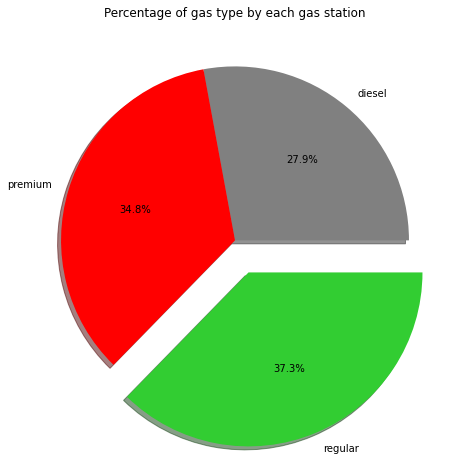

In [24]:
# Defining parameters
colors = ["grey", "red", "limegreen"]
explode = (0,0,0.2)

# Creating plot
plt.figure(figsize=(8,8))
plt.pie(x = gas_type_df["place_id"],labels= gas_type_df.index.values,explode=explode, colors=colors, autopct="%1.1f%%", shadow=True)
plt.title("Percentage of gas type by each gas station")
plt.savefig("Output_data/Pie_plot.png", dpi=100)
plt.show()


4. Creating subsets for each gas type to show 2 different Histograms

In [25]:
diesel = Mexico_Gas_Stations.loc[Mexico_Gas_Stations["gas type"]=="diesel"]
premium = Mexico_Gas_Stations.loc[Mexico_Gas_Stations["gas type"]=="premium"]
regular = Mexico_Gas_Stations.loc[Mexico_Gas_Stations["gas type"]=="regular"]
diesel["gas_price"].mode()
premium["gas_price"].mode()
regular["gas_price"].mode()
diesel.describe() # Price mean $19.08,std $1.09, median $19.00, mode $18.99 (positive skewed: mean>median>mode) 
premium.describe() # Price mean $18.89, std $1.39 and median $18.99, mode $18.99 (almost a nomal distribution: median=mode<~mean)
regular.describe() # Price mean $18.30, std $1.38 and median $18.50, mode $17.99 (negative skewed: mode<mean<median)
Fuels = ["Diesel", "Premium", "Regular"]
mean = ["$19.08", "$18.89", "$18.30"]
median = ["$19.00", "$18.99", "$18.50"]
mode = ["$18.99", "$18.99", "$17.99"]
std = ["$1.09", "$1.39", "$1.38"]
distribution = ["Positive skewed: mean>median>mode", "Almost a normal distribution: mean=~median=mode", "negative skewed: mode<mean<median"]
summary_prices = pd.DataFrame(list(zip(Fuels, mean, median, mode, std, distribution)))
summary_prices.columns = ["Fuels", "Mean", "Median", "Mode", "Standard Deviation", "Distribution"]
summary_prices

,Fuels,Mean,Median,Mode,Standard Deviation,Distribution
0,Diesel,$19.08,$19.00,$18.99,$1.09,Positive skewed: mean>median>mode
1,Premium,$18.89,$18.99,$18.99,$1.39,Almost a normal distribution: mean=~median=mode
2,Regular,$18.30,$18.50,$17.99,$1.38,negative skewed: mode<mean<median


5. Creating overlapped histogram to compare the behaviour of the prices between the three gas types

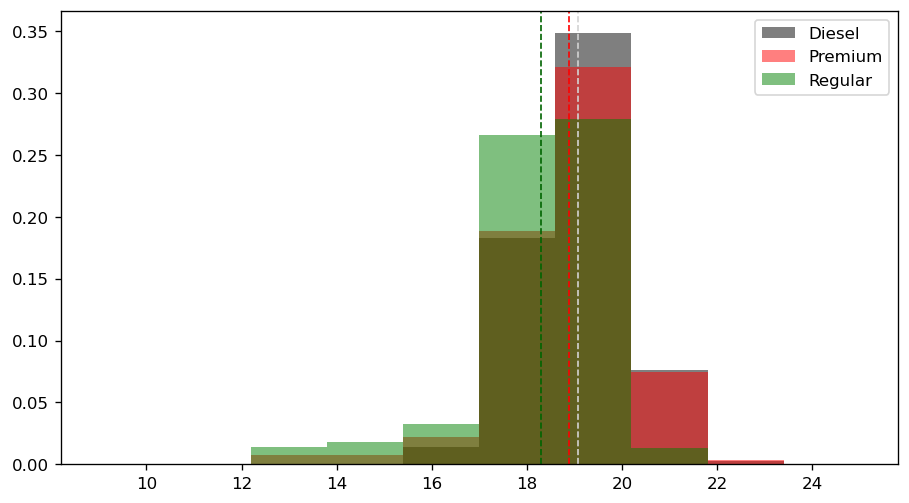

In [28]:
plt.figure(figsize=(9, 5), dpi=120)
plt.hist(diesel["gas_price"], 10,range=[9,25],color='black', density=True, alpha=0.5, label="Diesel")
plt.hist(premium["gas_price"], 10,range=[9,25], color='red', density=True, alpha=0.5, label="Premium")
plt.hist(regular["gas_price"], 10, range=[9,25], color='green', density=True, alpha=0.5, label="Regular")
plt.axvline(diesel["gas_price"].mean(), color='lightgray', linestyle='dashed', linewidth=1)
plt.axvline(premium["gas_price"].mean(), color='red', linestyle='dashed', linewidth=1)
plt.axvline(regular["gas_price"].mean(), color='darkgreen', linestyle='dashed', linewidth=1)
plt.legend()  
plt.savefig("Output_data/Histogram.png")
plt.show()

6. Creating 3 histograms to compare the behaviour of the ratings between the three gas types

In [29]:
regular_hist = Mexico_Gas_Stations.loc[Mexico_Gas_Stations["gas type"]=="regular"]
premium_hist = Mexico_Gas_Stations.loc[Mexico_Gas_Stations["gas type"]=="premium"]
diesel_hist = Mexico_Gas_Stations.loc[Mexico_Gas_Stations["gas type"]=="diesel"]

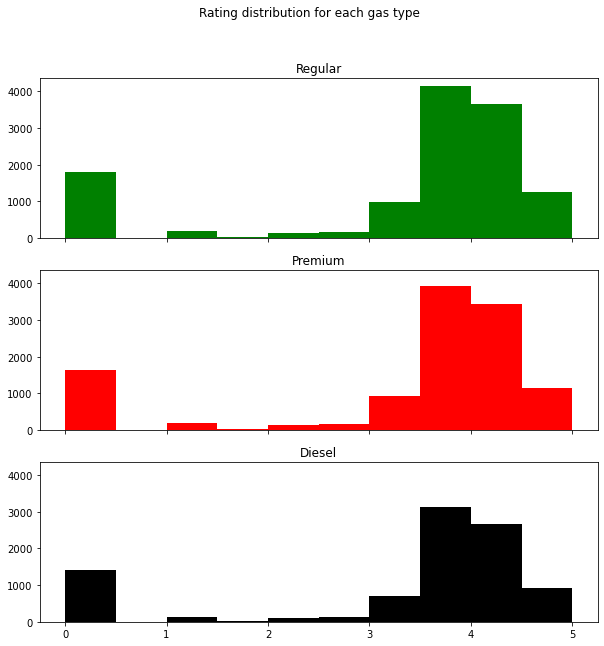

In [30]:
fig, axs = plt.subplots(3, sharex=True, sharey=True, figsize=(10,10))
fig.suptitle('Rating distribution for each gas type')
axs[0].hist(regular_hist["Rating"], color="green")
axs[1].hist(premium_hist["Rating"], color="red")
axs[2].hist(diesel_hist["Rating"], color="black")
axs[0].set_title('Regular')
axs[1].set_title('Premium')
axs[2].set_title('Diesel')
plt.savefig("Output_data/subplots.png")
plt.show()

6. Creating a boxplot from Ratings to check if there are any outliers

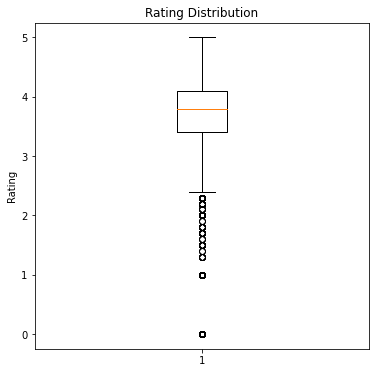

In [31]:
fig1, ax1 = plt.subplots(figsize=(6,6))
ax1.set_title('Rating Distribution')
ax1.set_ylabel('Rating')
ax1.boxplot(Mexico_Gas_Stations["Rating"])
plt.savefig("Output_data/boxplot.png")
plt.show()

7. We decided to create a DF using cut, getting the mean of User Ratings and Gas Price by a Rating scale

In [32]:
# bins for Rating
np.percentile(unique_stations_df["User Ratings"], np.arange(0,100, 20))
bins = [0,1,2,3,4,4.5,5]
names = ["<0.99", "1-1.99", "2-2.99", "3-3.99","4-4.49", "4.49-5.00"]
bins_rating = unique_stations_df
bins_rating["Ratings"]=pd.cut(bins_rating["Rating"], bins, labels=names)
bins_rating= bins_rating.groupby(["Ratings"])
bins_rating= bins_rating[["Ratings", "User Ratings", "gas_price"]]
bins_rating = bins_rating.mean()
bins_rating

,User Ratings,gas_price
Ratings,,
<0.99,1.223404,18.406064
1-1.99,2.342342,18.418468
2-2.99,7.935484,18.381154
3-3.99,78.232859,18.416396
4-4.49,69.401521,18.317422
4.49-5.00,9.546012,18.484755


In [33]:
count_stations = unique_stations_df
count_stations["Ratings"]=pd.cut(count_stations["Rating"], bins, labels=names)
count_stations= count_stations.groupby(["Ratings"])
count_stations= count_stations[["User Ratings"]]
count_stations = count_stations.count()
count_stations

,User Ratings
Ratings,
<0.99,188
1-1.99,111
2-2.99,589
3-3.99,6257
4-4.49,2498
4.49-5.00,978


--- 
## Part 4 - Finding new paths and mapping

1. As we didn't find any significant relationship, we got the gas station with the most User Ratings to check for any hint

In [34]:
# We use this code to show the whole string of the Types Column
pd.options.display.max_colwidth = 100

2. We found a very interesting data on the "Types" column

In [35]:
Mexico_Gas_Stations.loc[Mexico_Gas_Stations["User Ratings"]== Mexico_Gas_Stations["User Ratings"].max()].drop(columns="Rating")["Types"]

5482    gas_station, restaurant, food, point_of_interest, store, establishment
5483    gas_station, restaurant, food, point_of_interest, store, establishment
5484    gas_station, restaurant, food, point_of_interest, store, establishment
Name: Types, dtype: object

In [36]:
Mexico_Gas_Stations.iloc[5482:5485]

,name,cre_id,Lng,Lat,place_id,gas_price,gas type,Rating,User Ratings,Google_Name,Address,Types
5482,ESTACIÓN DE SERVICIOS POMAS SA DE CV,PL/2315/EXP/ES/2015,-103.3066,24.12847,4143,18.79,regular,4.4,2374.0,Truck Stop 001,"Km. 105.8, México 49, Juan Aldama","gas_station, restaurant, food, point_of_interest, store, establishment"
5483,ESTACIÓN DE SERVICIOS POMAS SA DE CV,PL/2315/EXP/ES/2015,-103.3066,24.12847,4143,19.09,premium,4.4,2374.0,Truck Stop 001,"Km. 105.8, México 49, Juan Aldama","gas_station, restaurant, food, point_of_interest, store, establishment"
5484,ESTACIÓN DE SERVICIOS POMAS SA DE CV,PL/2315/EXP/ES/2015,-103.3066,24.12847,4143,19.35,diesel,4.4,2374.0,Truck Stop 001,"Km. 105.8, México 49, Juan Aldama","gas_station, restaurant, food, point_of_interest, store, establishment"


3. As we found that the best gas station has more services to offer according to Types column, we went deep to analyze it

In [37]:
# Here, we are getting all the gas stations rated with 0 to check for the Types of services they offer
Min_UserRating = Mexico_Gas_Stations.loc[Mexico_Gas_Stations["User Ratings"]==0]
Min_UserRating = Min_UserRating[["gas_price", "Rating","Types","Address", "User Ratings"]]
Min_UserRating

,gas_price,Rating,Types,Address,User Ratings
18,19.29,0.0,"gas_station, point_of_interest, establishment","Calle 15 590, Joyas de Anahuac, Cd Gral Escobedo",0.0
19,20.39,0.0,"gas_station, point_of_interest, establishment","Calle 15 590, Joyas de Anahuac, Cd Gral Escobedo",0.0
20,19.49,0.0,"gas_station, point_of_interest, establishment","Calle 15 590, Joyas de Anahuac, Cd Gral Escobedo",0.0
21,17.65,0.0,"gas_station, point_of_interest, establishment","Av Rayon 876, Secc Primera, Obrera, Ensenada",0.0
22,18.69,0.0,"gas_station, point_of_interest, establishment","Av Rayon 876, Secc Primera, Obrera, Ensenada",0.0
...,...,...,...,...,...
33140,19.75,0.0,"gas_station, point_of_interest, establishment","Calle Postes 114, José María Pino Suárez, Ciudad de México",0.0
33141,19.15,0.0,"gas_station, point_of_interest, establishment","Calle Postes 114, José María Pino Suárez, Ciudad de México",0.0
33188,18.67,0.0,"gas_station, point_of_interest, establishment","Yautepec de Zaragoza-Jiutepec 17, San Jose, Jiutepec",0.0
33189,18.97,0.0,"gas_station, point_of_interest, establishment","Yautepec de Zaragoza-Jiutepec 17, San Jose, Jiutepec",0.0


In [38]:
Min_UserRating["Types"].unique()

array(['gas_station, point_of_interest, establishment',
       'gas_station, convenience_store, cafe, food, point_of_interest, store, establishment',
       'gas_station, atm, convenience_store, finance, food, point_of_interest, store, establishment',
       'gas_station, convenience_store, food, point_of_interest, store, establishment',
       'gas_station, convenience_store, car_repair, food, point_of_interest, store, establishment',
       'gas_station, atm, finance, cafe, food, point_of_interest, establishment'],
      dtype=object)

4. Then, we did the same for the Gas Stations who have greater User Ratings than the mean value

In [39]:
# We use the mean of user ratings as a measure to get everything above that mean.
Max_UserRating = Mexico_Gas_Stations.loc[(Mexico_Gas_Stations["User Ratings"]>=Mexico_Gas_Stations["User Ratings"].mean()) & (Mexico_Gas_Stations["User Ratings"]<=Mexico_Gas_Stations["User Ratings"].max())]
Max_UserRating = Max_UserRating[["gas_price", "Rating","Types","Address", "User Ratings"]]
Max_UserRating.head()

,gas_price,Rating,Types,Address,User Ratings
6,12.82,4.3,"gas_station, point_of_interest, establishment","Av. López Mateos 1604, La Plata, Cd Juárez",261.0
7,13.59,4.3,"gas_station, point_of_interest, establishment","Av. López Mateos 1604, La Plata, Cd Juárez",261.0
8,18.64,4.0,"gas_station, point_of_interest, establishment","Perif. Nte. Ricardo Flores Magón Ote. No. 950, Huentitán El Alto, Guadalajara",105.0
9,19.39,4.0,"gas_station, point_of_interest, establishment","Perif. Nte. Ricardo Flores Magón Ote. No. 950, Huentitán El Alto, Guadalajara",105.0
10,18.74,4.0,"gas_station, point_of_interest, establishment","Perif. Nte. Ricardo Flores Magón Ote. No. 950, Huentitán El Alto, Guadalajara",105.0


In [40]:
Max_UserRating["Types"].unique()

array(['gas_station, point_of_interest, establishment',
       'gas_station, convenience_store, cafe, food, point_of_interest, store, establishment',
       'gas_station, point_of_interest, store, establishment',
       'gas_station, atm, finance, cafe, food, point_of_interest, establishment',
       'gas_station, car_wash, point_of_interest, establishment',
       'gas_station, atm, convenience_store, finance, food, point_of_interest, store, establishment',
       'gas_station, convenience_store, food, point_of_interest, store, establishment',
       'gas_station, atm, convenience_store, finance, restaurant, food, point_of_interest, store, establishment',
       'gas_station, restaurant, food, point_of_interest, store, establishment',
       'gas_station, car_repair, point_of_interest, establishment',
       'gas_station, atm, finance, point_of_interest, establishment',
       'gas_station, convenience_store, restaurant, food, point_of_interest, store, establishment',
       'gas_stat

In [41]:
# Here, we check how many times every Type repeats for the best rated gas stations
unique_types = unique_stations_df.groupby(Max_UserRating["Types"]).count()["Address"].to_frame()
unique_types


,Address
Types,
"gas_station, atm, convenience_store, finance, food, point_of_interest, store, establishment",14
"gas_station, atm, convenience_store, finance, restaurant, food, point_of_interest, store, establishment",3
"gas_station, atm, finance, cafe, food, point_of_interest, establishment",60
"gas_station, atm, finance, point_of_interest, establishment",2
"gas_station, car_repair, point_of_interest, establishment",3
"gas_station, car_wash, point_of_interest, establishment",5
"gas_station, convenience_store, cafe, food, point_of_interest, store, establishment",43
"gas_station, convenience_store, food, point_of_interest, store, establishment",10
"gas_station, point_of_interest, establishment",3750


### Since it's not possible to do a deeper analysis because most of the gas stations are not properly clasified with all their services, we decided to stop here knowing that best rated gast stations have a correlation with the services they offer on the same location

5. We wanted to check if there was any specific geographic distribution of the gas stations with a scatter plot

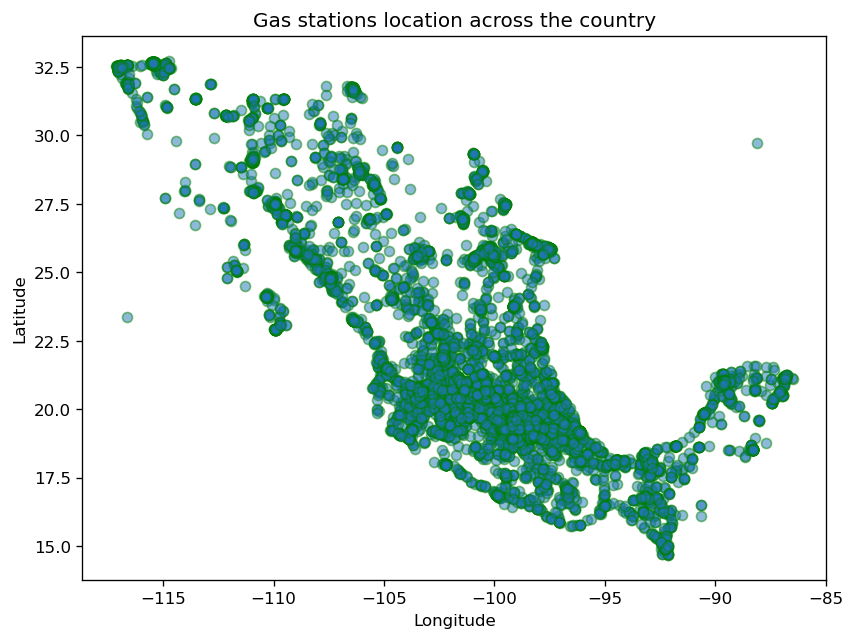

In [42]:
scatter_df = unique_stations_df.loc[unique_stations_df["Lng"]<=0]
plt.figure(figsize=(8, 6), dpi=120)
plt.scatter(scatter_df["Lng"],scatter_df["Lat"], edgecolor="green", alpha=0.5)
plt.title("Gas stations location across the country")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.savefig("Output_data/scatter_all.png")
plt.show()

10. We decided to do the same only for the best ratings (4 and above)

In [43]:
top_stations_df = unique_stations_df.loc[unique_stations_df["Rating"] >= 4]
top_stations_df = top_stations_df.loc[top_stations_df["Lng"]<=0]

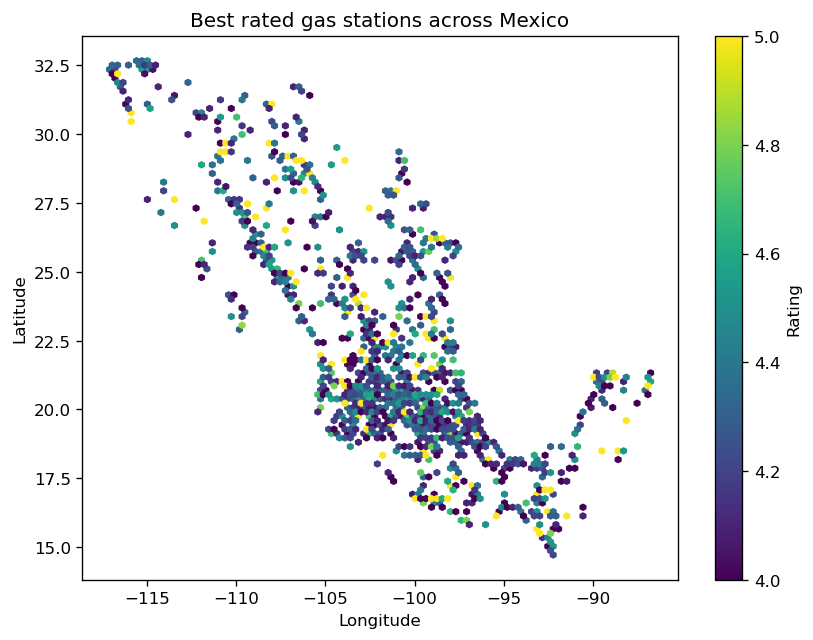

In [44]:
plt.figure(figsize=(8, 6), dpi=120)
plt.hexbin(top_stations_df["Lng"],top_stations_df["Lat"], C=top_stations_df["Rating"])
cb=plt.colorbar()
cb.set_label("Rating")
plt.title("Best rated gas stations across Mexico")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.savefig("Output_data/scatter_top.png")
plt.show()

---
## Part 4 - Heat Maps

1. We got the heat map of the gas stations in Mexico for 3 different categories:
---
### Top 100 best rating

In [45]:
best_rating_df = unique_stations_df.sort_values(by="Rating",ascending=False)
best_rating_df = best_rating_df.sort_values(by="User Ratings",ascending=False).head(100)
best_rating_df.head()

,name,cre_id,Lng,Lat,place_id,gas_price,gas type,Rating,User Ratings,Google_Name,Address,Types,Ratings
2071,ESTACIÓN DE SERVICIOS POMAS SA DE CV,PL/2315/EXP/ES/2015,-103.30660,24.12847,4143,18.79,regular,4.4,2374.0,Truck Stop 001,"Km. 105.8, México 49, Juan Aldama","gas_station, restaurant, food, point_of_interest, store, establishment",4-4.49
468,PARADERO STA MARIA S.A. DE C.V.,PL/817/EXP/ES/2015,-101.40970,26.75702,2507,18.48,regular,4.5,2078.0,Estación Monky's,"Carretera Federal 57 2502 COAH Estados Unidos Mexicanos, México 57 2502","gas_station, point_of_interest, establishment",4-4.49
2531,"BP ESTACIONES Y SERVICIOS ENERGETICOS, S.A. DE C.V.",PL/5400/EXP/ES/2015,-99.23764,19.49989,4705,19.09,regular,4.3,2014.0,bp,"Perif. Blvd. Manuel Ávila Camacho, Cd. Satélite, Naucalpan de Juárez","gas_station, convenience_store, cafe, food, point_of_interest, store, establishment",4-4.49
1162,"BP ESTACIONES Y SERVICIOS ENERGETICOS, S.A. DE C.V.",PL/1553/EXP/ES/2015,-99.12736,19.33902,3217,19.49,regular,4.2,2012.0,bp,"Calz Taxqueña, Paseos de Taxqueña, Ciudad de México","gas_station, convenience_store, food, point_of_interest, store, establishment",4-4.49
79,"GRUPO OCTANO, S.A. DE C.V.",PL/497/EXP/ES/2015,-100.79240,19.90187,2118,19.48,regular,3.8,1804.0,Pemex,"México 15D, Zinapecuaro de Figueroa","gas_station, point_of_interest, establishment",3-3.99


In [46]:
#Set api key
gmaps.configure(api_key=gkey)
#Set lat and lng as locations
locations = best_rating_df[["Lat","Lng"]]
#Set gas_price as weight
weight=best_rating_df["Rating"]

In [47]:
# Plot Best Rating Heatmap
fig = gmaps.figure()
max_intensity = np.max(weight)

# Create heat layer
heatmap = gmaps.heatmap_layer(
    locations, 
    weights = weight, 
    dissipating=False, 
    point_radius=.2)

# Add layer
fig.add_layer(heatmap)

# Display figure
fig

Figure(layout=FigureLayout(height='420px'))

* Aditionally, we added a marker layer for the best rated just to give some extra information about the best gas stations

In [48]:
info_box_template = """
<dl>
<dt>Name</dt><dd>{name}</dd>
<dt>City</dt><dd>{Address}</dd>
<dt>Rating</dt><dd>{Rating}</dd>
</dl>
"""
# Store the DataFrame Row
# NOTE: be sure to update with your DataFrame name
gas_info = [info_box_template.format(**row) for index, row in best_rating_df.iterrows()]
locations = best_rating_df[["Lat", "Lng"]]
# Add marker layer ontop of heat map
markers = gmaps.marker_layer(locations, info_box_content = gas_info)
markers
# Display Map
fig.add_layer(markers)

fig

Figure(layout=FigureLayout(height='420px'))

### Top 100 minimum prices

In [49]:
# Removing 0 User Ratings because they don't mean anything to the study
lowest_price_df = unique_stations_df.loc[unique_stations_df["User Ratings"]>0]
# Using only prices above 16.45 that correspond to the minimum price value reported at the end of 2017
lowest_price_df = lowest_price_df.loc[lowest_price_df["gas_price"]>16.45]
lowest_price_df = lowest_price_df.sort_values(by="Rating",ascending=False)
lowest_price_df = lowest_price_df.sort_values(by="User Ratings",ascending=False)
lowest_price_df = lowest_price_df.sort_values(by="gas_price",ascending=True).head(100)
lowest_price_df.head()

,name,cre_id,Lng,Lat,place_id,gas_price,gas type,Rating,User Ratings,Google_Name,Address,Types,Ratings
8956,SERVICIO BOCA SA DE CV,PL/3045/EXP/ES/2015,-96.16934,19.21568,11164,16.47,regular,4.3,134.0,PeMex,"Cerca de Tecnológico, Veracruz","gas_station, point_of_interest, establishment",4-4.49
9785,ISIGAS GUADALUPE SA DE CV,PL/10931/EXP/ES/2015,-100.17060,25.66982,13061,16.48,premium,3.0,2.0,Gasolinera Pemex,"Av Maestro Israel Cavazos Garza 125, Cerro Azul, Guadalupe","gas_station, point_of_interest, establishment",2-2.99
2461,NOVOGAS TOLLOCAN SA DE CV,PL/5933/EXP/ES/2015,-96.13433,19.19525,4635,16.48,regular,4.1,72.0,Pemex,"Av. Gral. Prim 132, Centro, Veracruz","gas_station, point_of_interest, establishment",4-4.49
5343,"Gasolinera Olympia de Veracruz, S.A. de C.V.",PL/6783/EXP/ES/2015,-96.13139,19.18961,7525,16.48,regular,3.8,111.0,Gasolinera Olympia de Veracruz,"Av. Gral. Prim 244-246, Ricardo Flores Magón, Veracruz","gas_station, point_of_interest, establishment",3-3.99
4083,Grupo Garcia Montaño SA de CV,PL/4196/EXP/ES/2015,-115.47870,32.65646,6262,16.49,regular,3.8,56.0,Pemex,"Bl, Boulevard Adolfo López Mateos N 820, Bella Vista, Mexicali","gas_station, point_of_interest, establishment",3-3.99


In [50]:
#Set api key
gmaps.configure(api_key=gkey)
#Set lat and lng as locations
locations = lowest_price_df[["Lat","Lng"]]
#Set Humidity as weight
weight=lowest_price_df["gas_price"]
# #Plot Heatmap
# fig = gmaps.figure
# max_intensity = np.max(weight)

In [51]:
# Plot Heatmap
fig = gmaps.figure()
max_intensity = np.max(weight)

# Create heat layer
heatmap = gmaps.heatmap_layer(
    locations, 
    weights = weight, 
    dissipating=False, 
    max_intensity=17, 
    point_radius=.2)

# Add layer
fig.add_layer(heatmap)

# Display figure
fig

Figure(layout=FigureLayout(height='420px'))

### Top 100 worst rated

In [52]:
worst_rating_df = unique_stations_df.sort_values(by="Rating",ascending=True) 
worst_rating_df = worst_rating_df.loc[worst_rating_df["User Ratings"]>worst_rating_df["User Ratings"].mean()]
worst_rating_df = worst_rating_df.sort_values(by="Rating",ascending=True).head(100)
worst_rating_df.head()

,name,cre_id,Lng,Lat,place_id,gas_price,gas type,Rating,User Ratings,Google_Name,Address,Types,Ratings
1883,ESTACIÓN DE SERVICIO LOS AVALLANOS S.A. DE C.V.,PL/2437/EXP/ES/2015,-86.85023,21.03732,3938,19.89,regular,2.5,476.0,Pemex,"Reserva Territorial ""Sascaberas"", Mz 11 Lote 01 299, Supermanzana","gas_station, point_of_interest, establishment",2-2.99
6010,"OPERADORA DE ESTACIONES DE SERVICIO 20-20, S.A. DE C.V.",PL/6711/EXP/ES/2015,-109.70940,23.15160,8193,19.84,regular,2.7,130.0,Pemex,"La Paz-San José del Cabo Mz 3-C LT L-2, Las Veredas","gas_station, point_of_interest, establishment",2-2.99
4587,"Estación de Servicios Palmas Cancún, S.A. de C.V.",PL/4031/EXP/ES/2015,-86.84990,21.04280,6769,19.69,regular,2.8,81.0,Gasolinera Pemex,"Lote 6-01,6-02 Y 6-03 Carretera Cancun, Puerto Juárez Km.17, Rancho Santa Ana","gas_station, point_of_interest, establishment",2-2.99
572,SERVICIOS PLAYACAR S.A. DE C.V.,PL/1482/EXP/ES/2015,-87.07149,20.64288,2625,19.99,regular,2.8,106.0,PEMEX,"Carr. Cancún - Tulum manzana 51, Luis Donaldo Colosio, Playa del Carmen","gas_station, point_of_interest, establishment",2-2.99
1124,INMOBILIARIA OSTUNI S.A. DE C.V.,PL/2040/EXP/ES/2015,-86.93461,20.49878,3179,19.84,regular,2.8,150.0,Pemex,"Av Lic Benito Juárez 73, Emiliano Zapata, San Miguel de Cozumel","gas_station, point_of_interest, establishment",2-2.99


In [53]:
#Set api key
gmaps.configure(api_key=gkey)
#Set lat and lng as locations
locations = worst_rating_df[["Lat","Lng"]]
#Set gas_price as weight
weight=worst_rating_df["Rating"]

In [54]:
# Plot Best Rating Heatmap
fig = gmaps.figure()
max_intensity = np.max(weight)

# Create heat layer
heatmap = gmaps.heatmap_layer(
    locations, 
    weights = weight, 
    dissipating=False, 
    point_radius=.2)

# Add layer
fig.add_layer(heatmap)

# Display figure
fig

Figure(layout=FigureLayout(height='420px'))

## Part 5 - Conclusions

- There is no relation between the user ratings and the fuel price.
- There’s a relation between the rating and the features or added services of each of the Service Stations.
- There is not enough measurable data to determine specifically which aspect of the added services drives up the rating.
- Fuel is cheaper near the border.
- Data required to be reported by the government is insufficient to procure a thorough analysis.
- A more complete analysis requires gathering additional data from other sources, such as mobility, type of services offered, cost of distribution, and more.